### Magics

In [2]:
%load_ext sql

In [3]:
%env DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos

env: DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos


### Imports y utils

In [4]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import spacy
import pickle

from unionfind import UnionFind

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 5]

import statistics

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


In [5]:
def summarize(l: list):
    print("Size:", len(l), sep="\t")
    print("Min:", min(l), sep="\t")
    print("Median:", statistics.median(l), sep="\t")
    print("Max:", max(l), sep="\t")
    print("Avg:", sum(l) / len(l), sep="\t")
    print("Mode:", statistics.mode(l), sep="\t")

---

### Cargar datos

Usamos abril-junio de 2018 como rango de tiempo

In [6]:
%%sql mensajes <<

SELECT * 
FROM MENSAJES_INGENIERIA
WHERE MEN_CENSURADO = 0
AND DATE(MEN_FECHA_CREACION) >= '2018-04-01' AND DATE(MEN_FECHA_CREACION) < '2018-07-01'

11883 rows affected.
Returning data to local variable mensajes


In [7]:
df = mensajes.DataFrame()

In [8]:
df.head()

,MEN_ID,MEN_TEM_ID,MEN_TEM_NOMBRE,MEN_MEN_ID,MEN_RUT,MEN_TITULO,MEN_CONTENIDO,MEN_CENSURADO,MEN_RAIZ,MEN_FECHA_CREACION,MEN_ULTIMO_MEN_ID,MEN_AUTORIDAD,MEN_FECHA_M,MEN_INSTITUCIONES
0,2109395,37,Actividades Extraprogramáticas,0,6674,"Primera junta del semestre, Com. de Apoyo a la...",Hace ya un par de semanas que empezó este seme...,0,0,2018-04-01 00:26:43,2110305,0,2018-04-07 23:38:38,
1,2109403,36,Temas Generales,2109203,3584,Re (11): Encuesta +1/-1: Usas twitter?,-1##@@##2078,0,2108627,2018-04-01 09:48:27,0,0,2018-04-01 09:48:27,
2,2109409,36,Temas Generales,2107655,3584,"Re (3): [Vendo]: Notebook, Mass Effect, otros",Vi tu avatar y Link y pense que era algo de ze...,0,2107655,2018-04-01 10:09:16,0,0,2018-04-01 10:09:16,
3,2109419,36,Temas Generales,0,4879,Hoy vence plazo solicitud monto CAE renovantes.,Eso. Para el que aún no lo ha hecho.##@@##2078,0,0,2018-04-01 13:53:49,2109891,0,2018-04-02 22:41:36,
4,2109427,37,Actividades Extraprogramáticas,0,7054,Ucoins,Alguien más minando?##@@##2078,0,0,2018-04-01 14:33:20,2109803,0,2018-04-03 15:25:45,


In [9]:
print("cantidad de temas en el periodo")
len(df.loc[df.MEN_MEN_ID == 0].index)

cantidad de temas en el periodo


1362

### Script para obtener un tema de discusión (árbol)

In [168]:
%%sql

select MEN_ID, MEN_TITULO, MEN_MEN_ID
from MENSAJES_INGENIERIA
where MEN_ID = '2109419'

union

select  MEN_ID,
        MEN_TITULO,
        MEN_MEN_ID 
from    (select * from MENSAJES_INGENIERIA
         order by MEN_MEN_ID, MEN_ID) mensajes_sorted,
        (select @pv := '2109419') initialisation
where   find_in_set(MEN_MEN_ID, @pv)
and     length(@pv := concat(@pv, ',', MEN_ID))



 * mysql+mysqlconnector://root@localhost/ucursos
5 rows affected.


MEN_ID,MEN_TITULO,MEN_MEN_ID
2109419,Hoy vence plazo solicitud monto CAE renovantes.,0
2109585,Re (1): Hoy vence plazo solicitud monto CAE renovantes.,2109419
2109607,Re (2): Hoy vence plazo solicitud monto CAE renovantes.,2109419
2109889,Re (3): Hoy vence plazo solicitud monto CAE renovantes.,2109607
2109891,Re (4): Hoy vence plazo solicitud monto CAE renovantes.,2109889


### Union Find para generar temas

In [170]:
uf = UnionFind()

for _, row in tqdm(df.iterrows(), total=len(df.index)):
    if row.MEN_MEN_ID == 0:
        uf.add(int(row.MEN_ID))
        
for _, row in tqdm(df.iterrows(), total=len(df.index)):
    if row.MEN_MEN_ID != 0:
        uf.union(int(row.MEN_ID), int(row.MEN_MEN_ID))


In [171]:
temas = list(uf.components())

In [172]:
for tema in temas:
    if 2109419 in tema:
        print(tema)

{2109889, 2109891, 2109607, 2109419, 2109585}


In [173]:
print("cantidad de temas obtenidos")
print(len(temas))
print("(esto puede deberse a que hay temas que empezaron antes del periodo)")

cantidad de temas obtenidos
6758
(esto puede deberse a que hay temas que empezaron antes del periodo)


In [174]:
mensajes_por_tema = [len(tema) for tema in temas]
summarize(mensajes_por_tema)

Size:	6758
Min:	1
Median:	2.0
Max:	101
Avg:	6.1277005031074285
Mode:	1


In [175]:
for tema in temas:
    if len(tema) > 100:
        print(tema)
        tema_101 = tema
        break

{2210824, 2210826, 2210828, 2210830, 2211860, 2211864, 2211866, 2211868, 2211874, 2211878, 2211890, 2210886, 2211910, 2211914, 2211916, 2211428, 2211940, 2211448, 2211450, 2211454, 2211968, 2211462, 2211464, 2211470, 2211984, 2211484, 2211996, 2210474, 2211504, 2210484, 2211510, 2211522, 2211540, 2211542, 2211544, 2210524, 2210528, 2211554, 2212070, 2211564, 2212080, 2212082, 2211572, 2211580, 2211588, 2211594, 2212116, 2212118, 2210586, 2212124, 2212128, 2212136, 2212140, 2212142, 2212146, 2212148, 2212152, 2210622, 2212160, 2211650, 2212162, 2211652, 2212168, 2211658, 2212170, 2212178, 2210644, 2211668, 2212180, 2211676, 2212192, 2211682, 2212196, 2212198, 2211688, 2212200, 2212202, 2212206, 2212208, 2211698, 2212210, 2212214, 2212220, 2212224, 2212226, 2211716, 2211718, 2211720, 2212232, 2212234, 2212236, 2210702, 2212238, 2210714, 2210718, 2212256, 2212276, 2211772, 2212288, 2212318, 2211810}


In [176]:
for m_id in tema_101:
    if not df[df.MEN_ID == m_id][df.MEN_MEN_ID == 0].empty:
        print(m_id)

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


2210474


**Los temas pueden tener 101 mensajes**: el inicial y hasta 100 respuestas

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'cantidad de temas'),
 Text(0.5, 0, 'cantidad de mensajes en un tema')]

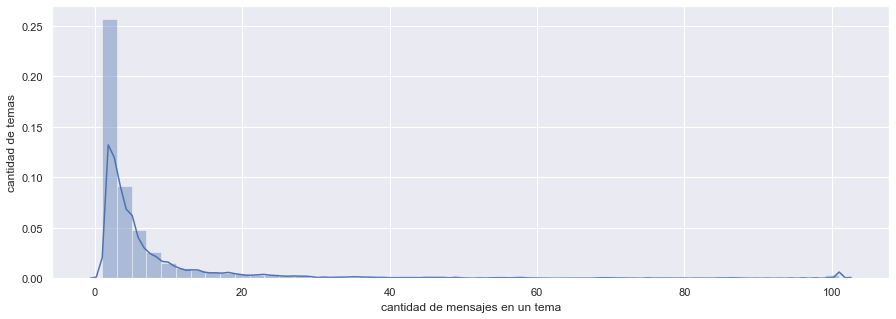

In [53]:
ax = sns.distplot(mensajes_por_tema)
ax.set(xlabel="cantidad de mensajes en un tema", ylabel="cantidad de temas")

### Usuarios por tema

In [71]:
rut_msg = dict()

for _, row in df.iterrows():
    rut_msg[row.MEN_ID] = row.MEN_RUT

In [72]:
ruts_temas = []

for tema in temas:
    ruts = []
    for msg_id in tema:
        rut = rut_msg.get(msg_id)
        if rut:
            ruts.append(rut)
    ruts_temas.append(ruts)

usuarios_temas = [len(tema) for tema in ruts_temas]
uniq_usuarios_temas = [len(set(tema)) for tema in ruts_temas]

In [75]:
summarize(usuarios_temas)  # lo mismo que los mensajes

Size:	6758
Min:	1
Median:	2.0
Max:	101
Avg:	6.120745782775969
Mode:	1


In [74]:
summarize(uniq_usuarios_temas)

Size:	6758
Min:	1
Median:	2.0
Max:	101
Avg:	4.281592187037585
Mode:	1


[Text(0, 0.5, 'cantidad de temas'),
 Text(0.5, 0, 'cantidad de usuarios unicos participando en un tema')]

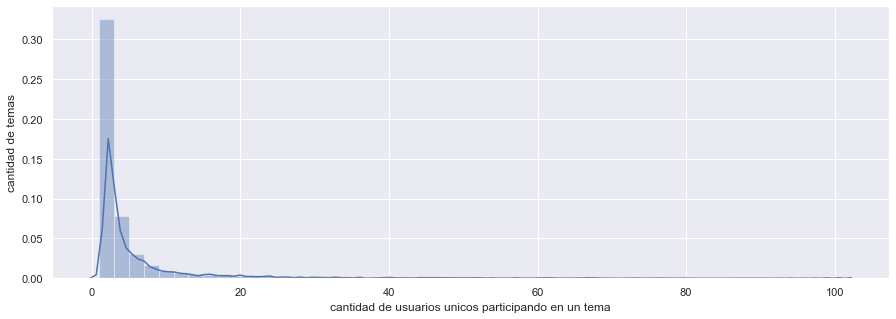

In [77]:
ax = sns.distplot(uniq_usuarios_temas)
ax.set(xlabel="cantidad de usuarios unicos participando en un tema", ylabel="cantidad de temas")


### Grafos de conversaciones por tema

In [88]:
responde_a = dict()

for _, row in tqdm(df.iterrows(), total=len(df.index)):
    if row.MEN_MEN_ID != 0 and rut_msg.get(row.MEN_MEN_ID):
        responde_a[row.MEN_ID] = (row.MEN_RUT, rut_msg[row.MEN_MEN_ID])

In [93]:
# explorar temas: 
# https://www.u-cursos.cl/ingenieria/2/foro_institucion/o/2123179

conversaciones = []

for tema in tqdm(temas):
    conversacion = []
    for men_id in tema:
        par = responde_a.get(men_id)
        if par:
            conversacion.append(par)
    conversaciones.append(conversacion)

In [104]:
i = 10
conversaciones[i], temas[i]

([(20239608, 19829954),
  (19829954, 20239608),
  (20239608, 19829954),
  (20136935, 19829954),
  (19829954, 20239608),
  (20239608, 19829954),
  (20242480, 19829954),
  (17962622, 19829954),
  (20071946, 17962622),
  (19829954, 17962622),
  (19525028, 19829954)],
 {2204334,
  2204354,
  2204356,
  2204358,
  2204362,
  2204364,
  2204374,
  2204378,
  2204472,
  2204658,
  2204710,
  2204860})

In [133]:
for i, conversacion in enumerate(conversaciones):
    if len(conversacion) > 49:
        print(i)
        break

108


### grafos de conversaciones

In [110]:
G = nx.DiGraph()
G.add_edges_from(conversaciones[10])

In [112]:
G.edges

OutEdgeView([(20239608, 19829954), (19829954, 20239608), (19829954, 17962622), (20136935, 19829954), (20242480, 19829954), (17962622, 19829954), (20071946, 17962622), (19525028, 19829954)])

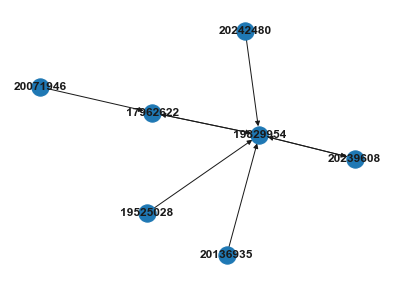

In [117]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

El problema es que no considera los pesos de las aristas (una persona que responde mas de una vez a la misma. Quizás verlo como árbol?

In [121]:
# explorar temas: 
# https://www.u-cursos.cl/ingenieria/2/foro_institucion/o/2204334

msg_responde = dict()

for _, row in tqdm(df.iterrows(), total=len(df.index)):
    if row.MEN_MEN_ID != 0:
        msg_responde[row.MEN_ID] = row.MEN_MEN_ID

msg_conversaciones = []

for tema in tqdm(temas):
    conversacion = []
    for men_id in tema:
        men_men_id = msg_responde.get(men_id)
        if men_men_id:
            conversacion.append((men_id, men_men_id))
    msg_conversaciones.append(conversacion)

In [122]:
i = 10
msg_conversaciones[i], temas[i]

([(2204354, 2204334),
  (2204356, 2204354),
  (2204358, 2204356),
  (2204710, 2204378),
  (2204362, 2204358),
  (2204364, 2204362),
  (2204658, 2204334),
  (2204374, 2204334),
  (2204472, 2204374),
  (2204378, 2204374),
  (2204860, 2204378)],
 {2204334,
  2204354,
  2204356,
  2204358,
  2204362,
  2204364,
  2204374,
  2204378,
  2204472,
  2204658,
  2204710,
  2204860})

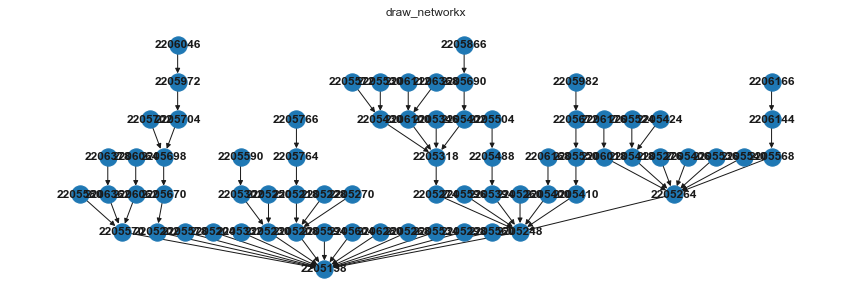

In [134]:
G = nx.DiGraph()
G.add_edges_from(msg_conversaciones[108])
#plt.subplot(121)
#nx.draw(G, with_labels=True, font_weight='bold')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True, font_weight='bold')

In [152]:
[x[0] for x in sorted(enumerate(msg_conversaciones), key=lambda x: -len(x[1]))][:10]

[696, 1509, 2093, 2155, 2185, 2509, 2542, 3004, 3704, 4048]

In [153]:
plt.rcParams['figure.figsize'] = [15, 15]

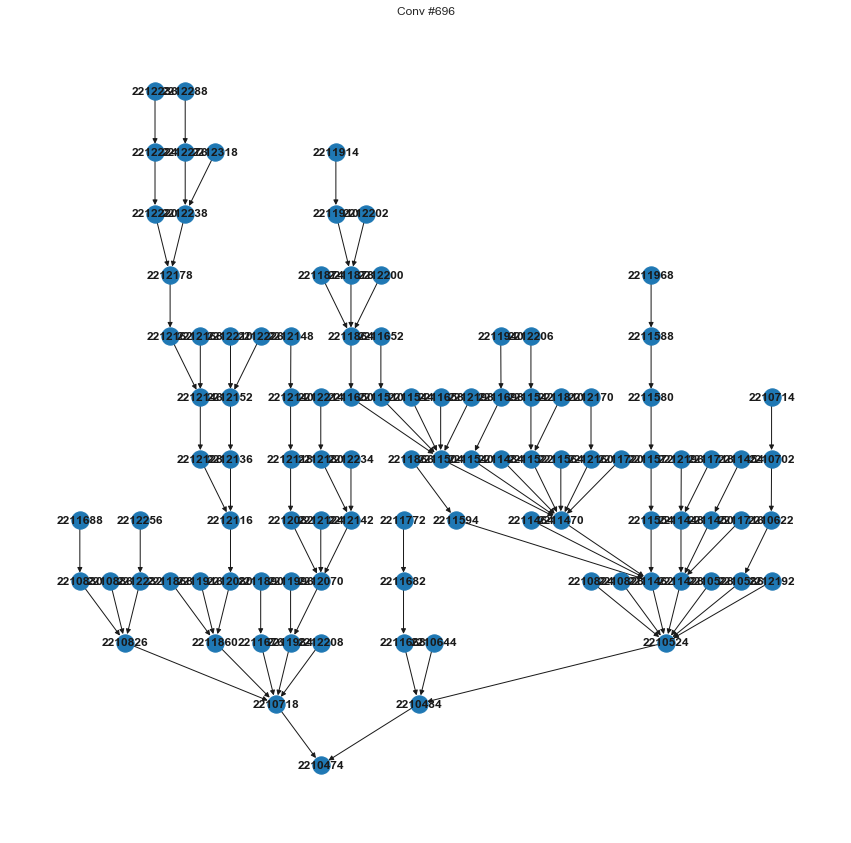

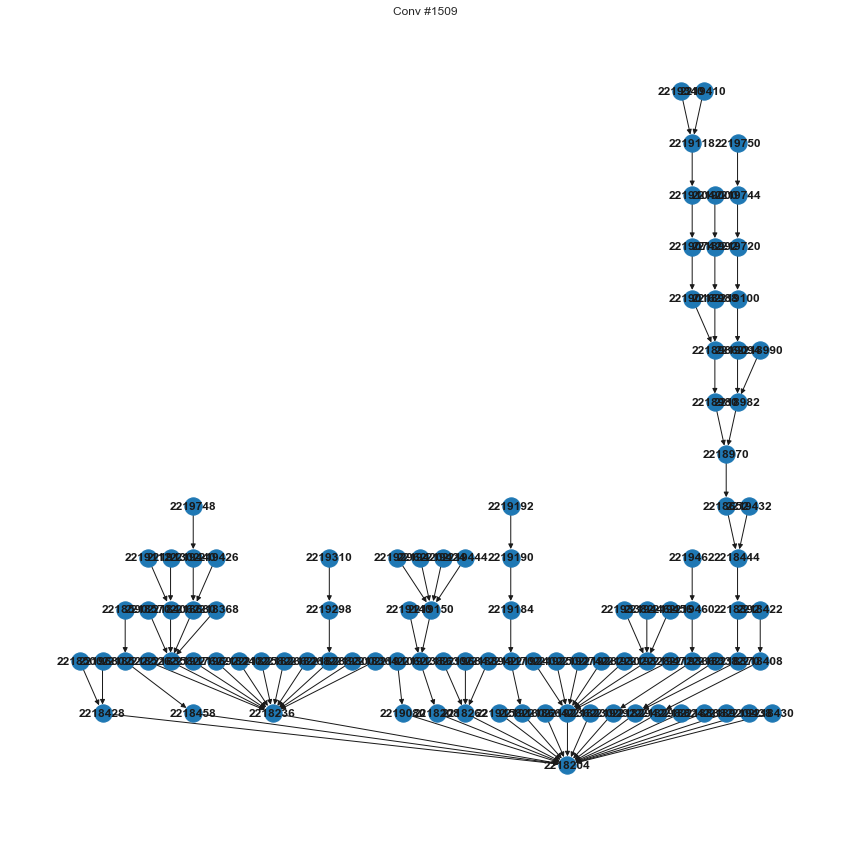

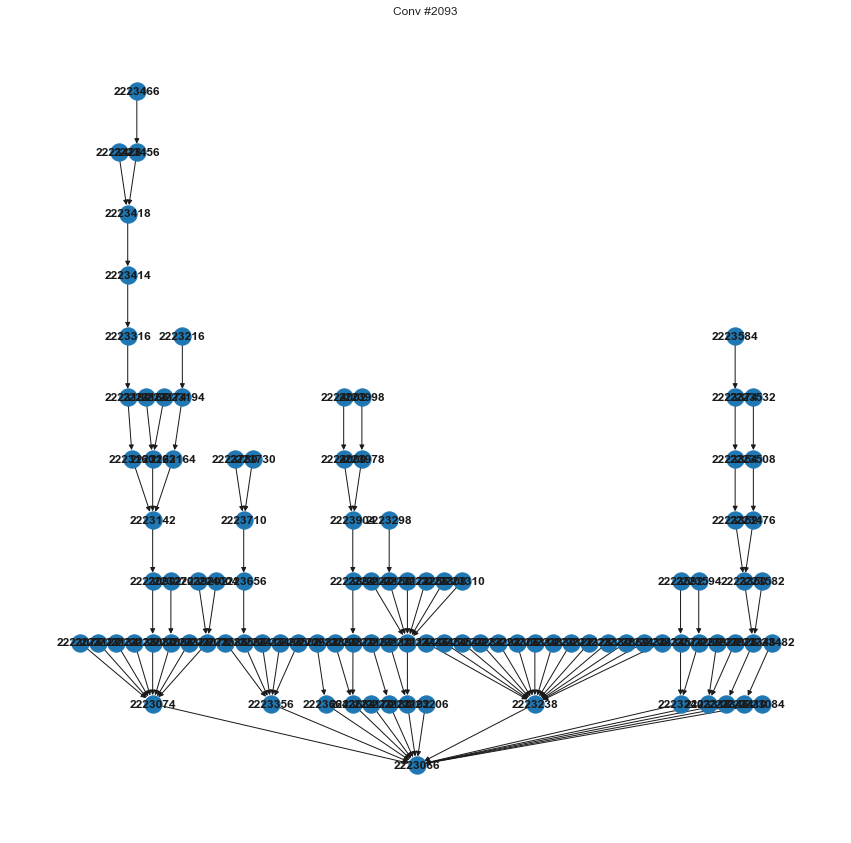

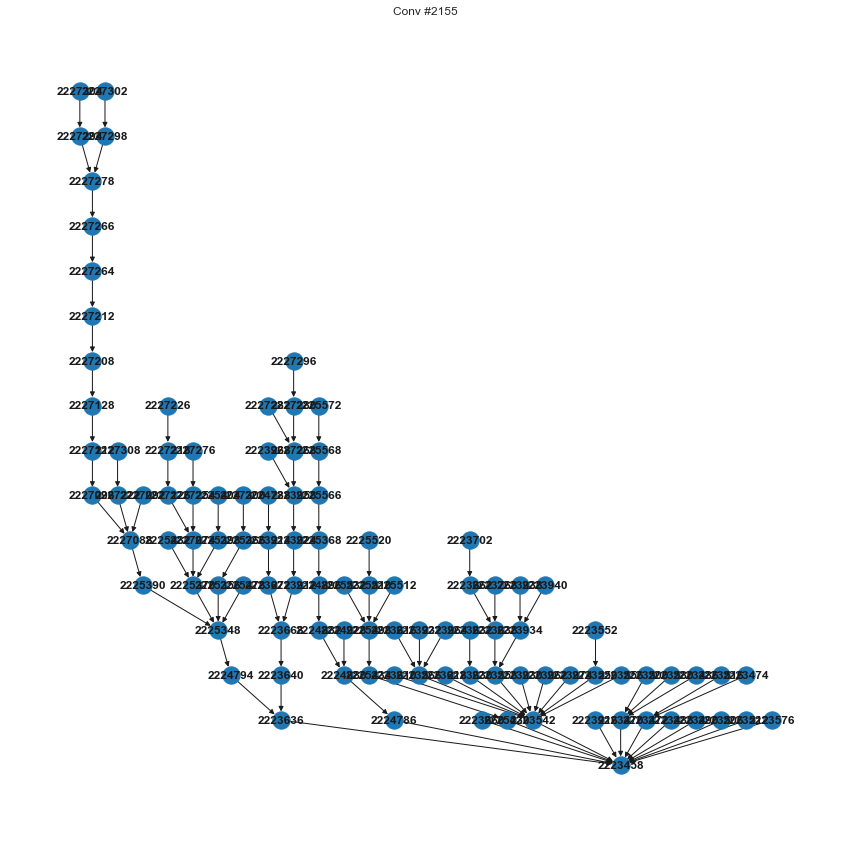

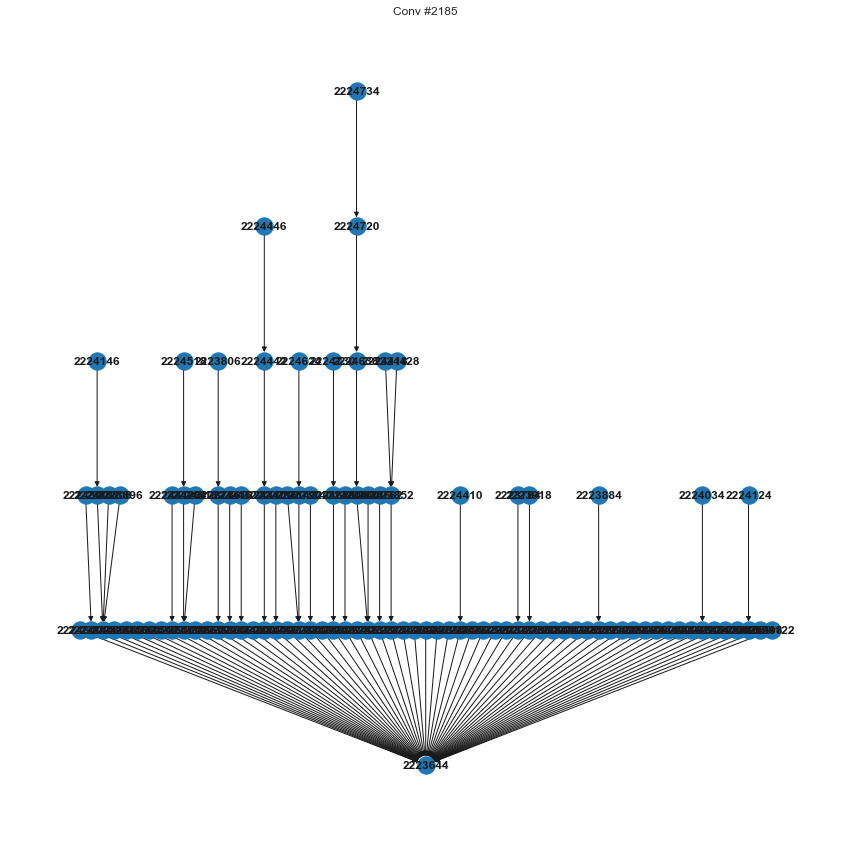

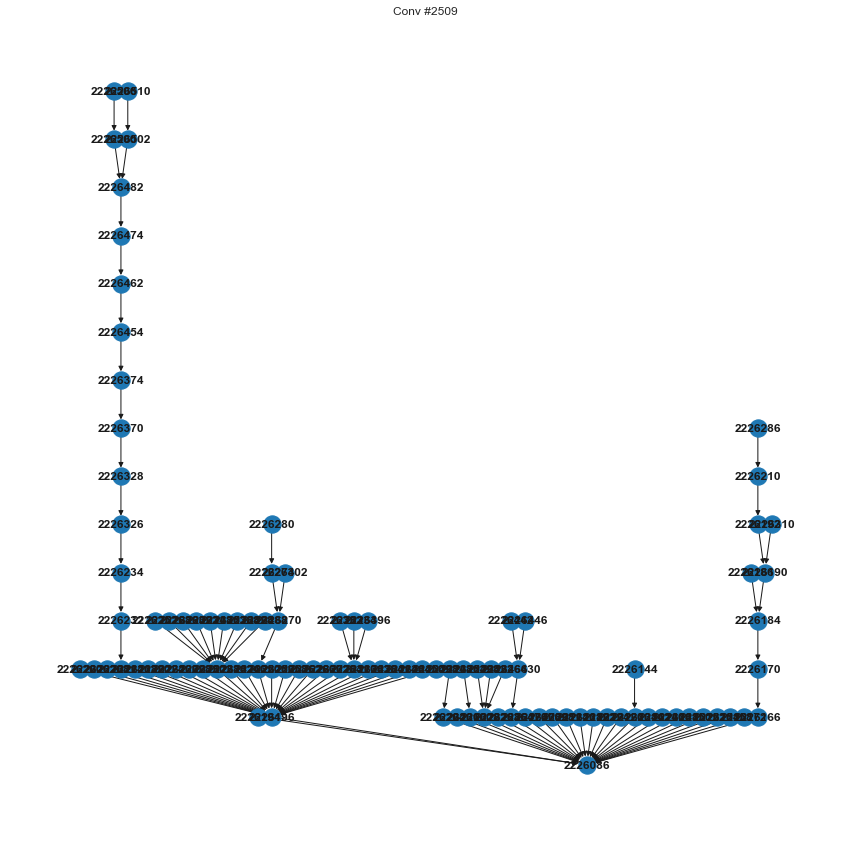

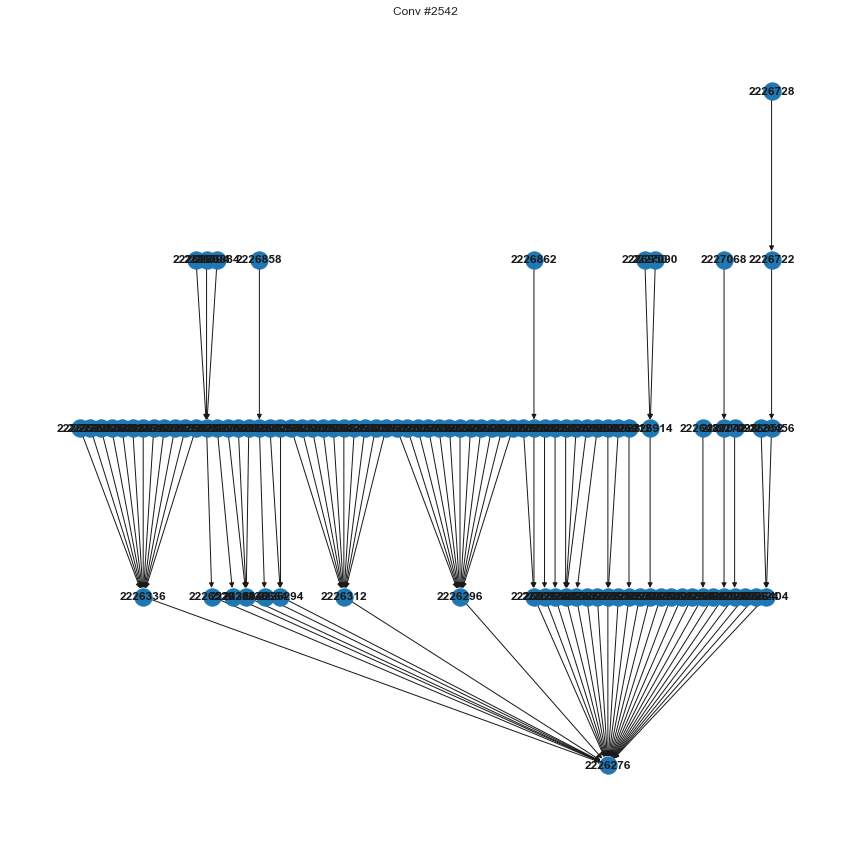

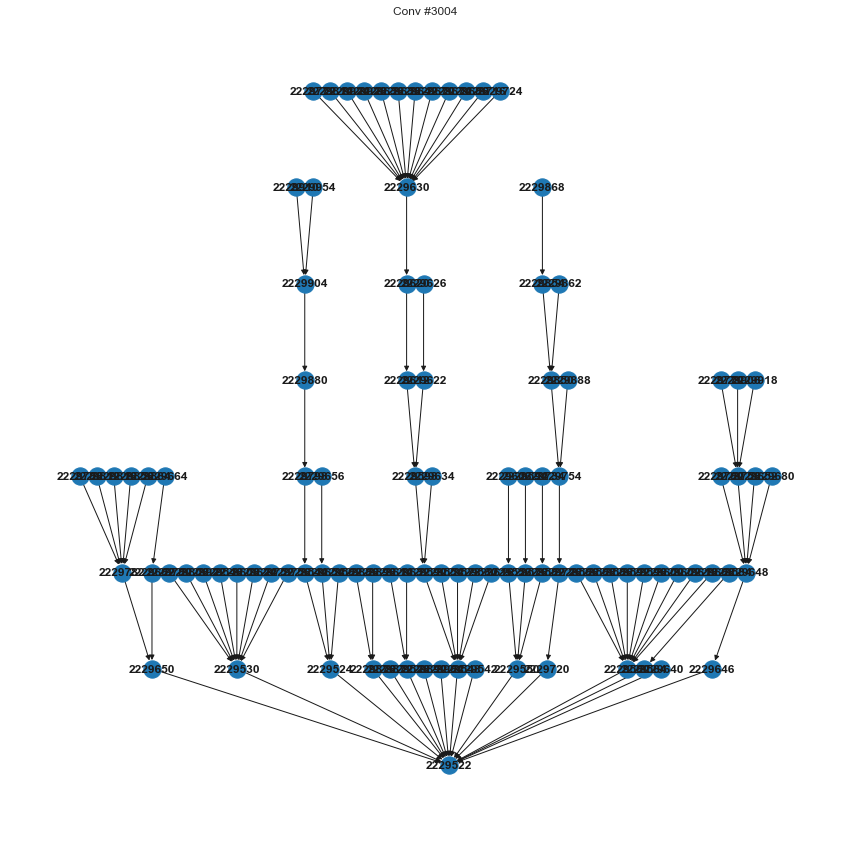

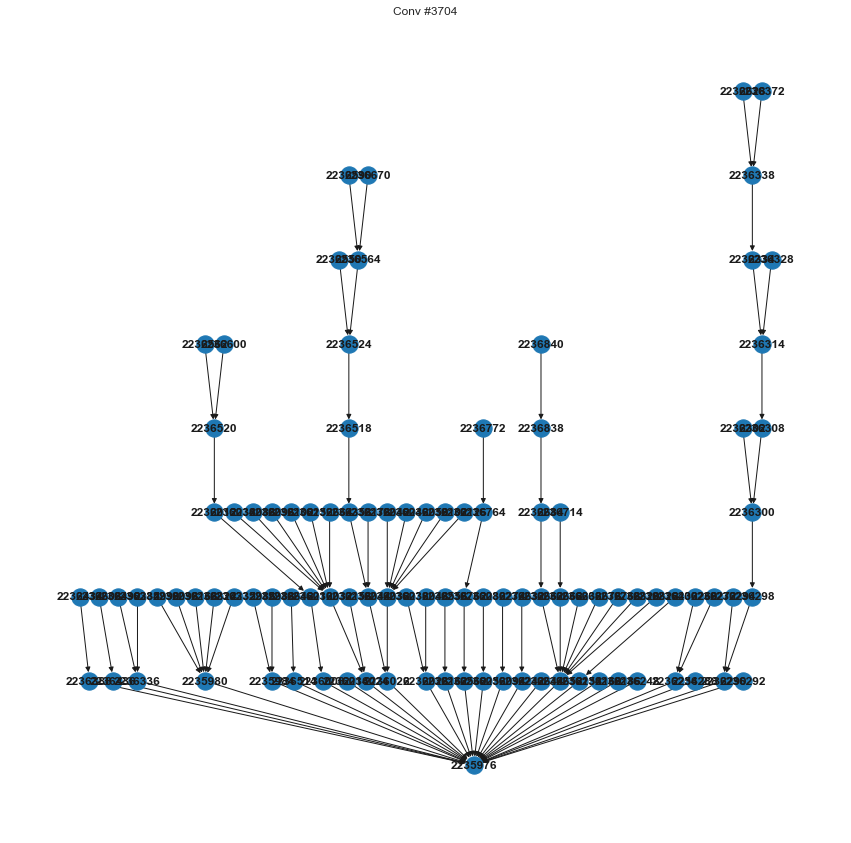

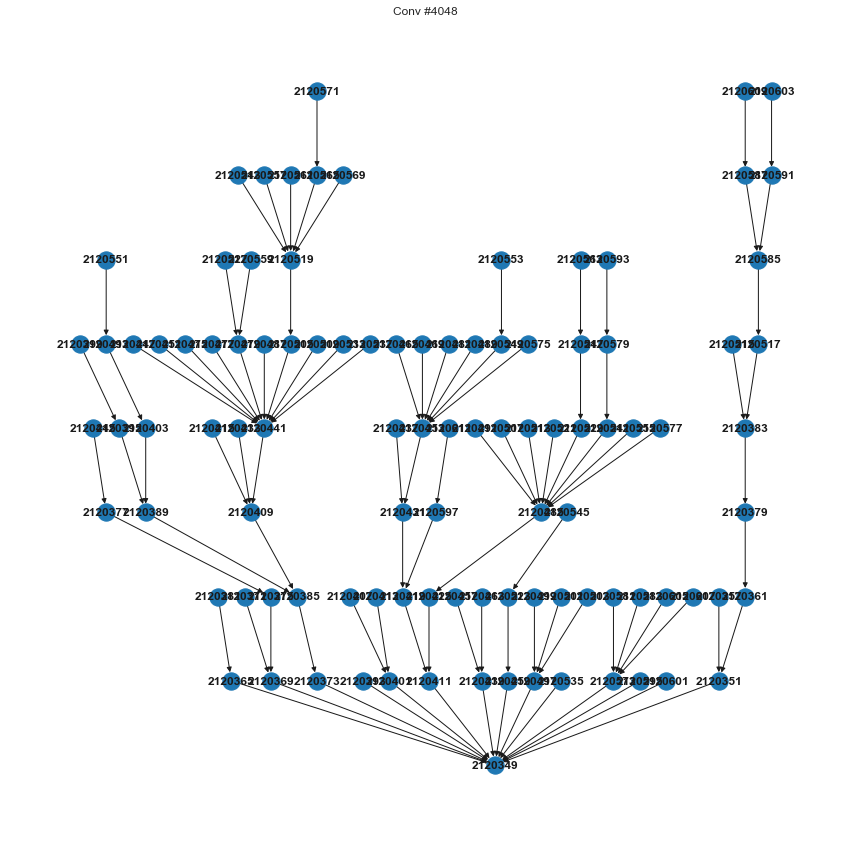

In [158]:
for idx in [x[0] for x in sorted(enumerate(msg_conversaciones), key=lambda x: -len(x[1]))][:10]:
    G = nx.DiGraph()
    G.add_edges_from(msg_conversaciones[idx])
    plt.figure()
    plt.title(f'Conv #{idx}')
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, arrows=True, font_weight='bold')